## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Downloading Price Data

In [2]:
chosen_ticker = "GOOG"
chosen_stock = yf.Ticker(chosen_ticker)

df = pd.DataFrame(chosen_stock.history(start = '2020-01-01', end = '2024-03-09')['Close'])
df = df.rename(columns = {'Close' : 'Price'})

## Visualizing Our Data

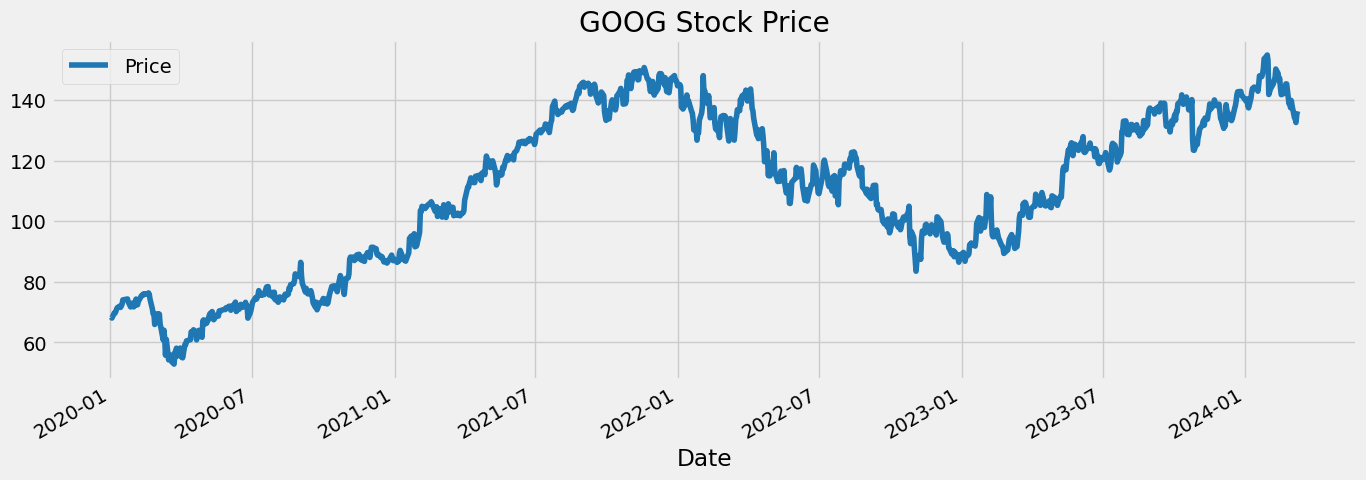

In [3]:
df.plot(figsize = (15,5), 
        color = color_pal[0], 
        title = f'{chosen_ticker} Stock Price')
plt.show()

## Time Series Split

In [4]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 10) # test and gap in days, 252/4 = 83 trading days/ quarter
df = df.sort_index()

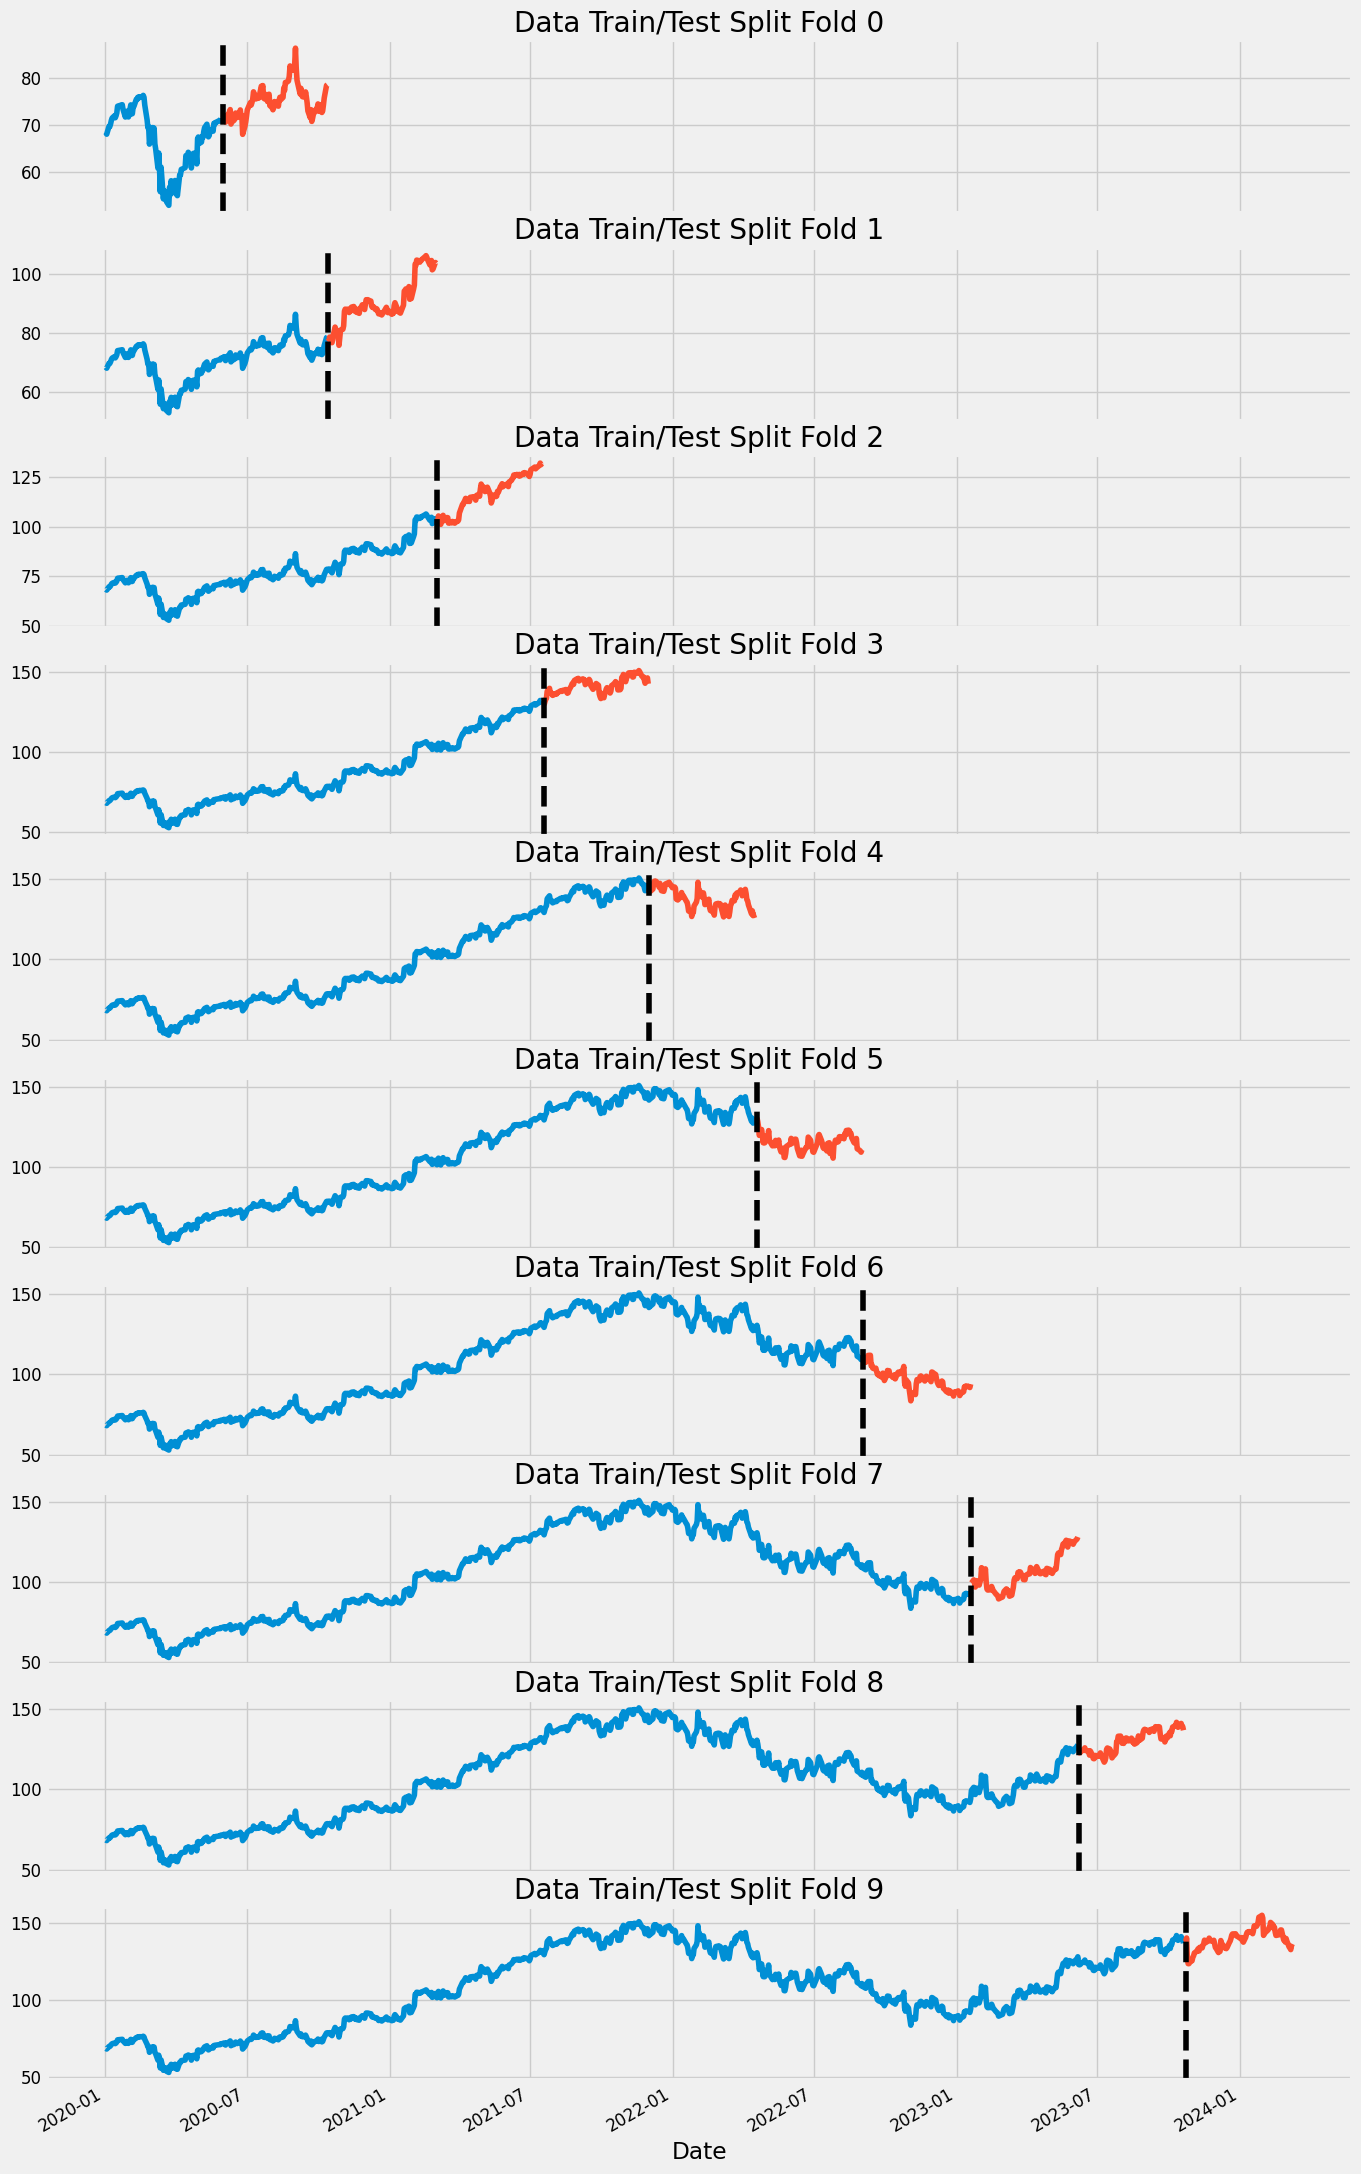

In [5]:
fig, axs = plt.subplots(10, 1, figsize = (15, 30), sharex = True)

fold = 0

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['Price'].plot(ax = axs[fold],
                        label = 'Training Set',
                        title = f'Data Train/Test Split Fold {fold}',
                        fontsize = 12)
    
    test['Price'].plot(ax = axs[fold],
                       label = 'Test Set')
    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1
    
plt.show()

## Main Feature Creation

In [6]:
def create_features(df):
    
    df = df.copy()
    
    # Time Features
    df['DayOfYear']  = df.index.dayofyear
    df['DayOfMonth'] = df.index.day
    df['DayOfWeek']  = df.index.dayofweek
    df['Year']       = df.index.year
    df['Quarter']    = df.index.quarter
    df['Month']      = df.index.month
    # df['WeekOfYear'] = df.index.isocalendar().week
    
    # Adding Macro Variables
    df['3M_TBill'] = pd.DataFrame(yf.Ticker('^IRX').history(start = '2020-04-01', end = '2023-06-30')['Open'])
    
    return df

In [7]:
df = create_features(df)

## Lag Features

In [9]:
def create_lag(df):
    # NOTE: A lag variable is a variable based on the past values of the time series
    # Not a used lag variable, but used for return feature calculations
    df['LogReturn'] = np.log(df.Price.pct_change() + 1)
    
    # Trailing features
    df['1D_TrailingReturn'] = df['LogReturn'].rolling(1).sum().shift(1)
    df['1W_TrailingReturn'] = df['LogReturn'].rolling(5).sum().shift(1)
    df['2W_TrailingReturn'] = df['LogReturn'].rolling(10).sum().shift(1)
    df['3W_TrailingReturn'] = df['LogReturn'].rolling(15).sum().shift(1)
    df['4W_TrailingReturn'] = df['LogReturn'].rolling(20).sum().shift(1)
    
    df['1D_PosRet'] = (df['1D_TrailingReturn'] > 0).astype('int')
    df['1W_PosRet'] = (df['1W_TrailingReturn'] > 0).astype('int')
    df['2W_PosRet'] = (df['2W_TrailingReturn'] > 0).astype('int')
    df['3W_PosRet'] = (df['3W_TrailingReturn'] > 0).astype('int')
    df['4W_PosRet'] = (df['4W_TrailingReturn'] > 0).astype('int')
    
    df['1W_TrailingVolatility']  = (df['Price'].pct_change().rolling(5).std()*(252**0.5)).shift(1) # Annualized
    df['2W_TrailingVolatility']  = (df['Price'].pct_change().rolling(10).std()*(252**0.5)).shift(1) # Annualized
    df['3W_TrailingVolatility']  = (df['Price'].pct_change().rolling(15).std()*(252**0.5)).shift(1) # Annualized
    df['4W_TrailingVolatility']  = (df['Price'].pct_change().rolling(20).std()*(252**0.5)).shift(1) # Annualized
    
    df['1W_TrailingSharpeRatio'] = (df['1W_TrailingReturn'] - df['3M_TBill']) / df['1W_TrailingVolatility']
    df['2W_TrailingSharpeRatio'] = (df['2W_TrailingReturn'] - df['3M_TBill']) / df['2W_TrailingVolatility']
    df['3W_TrailingSharpeRatio'] = (df['3W_TrailingReturn'] - df['3M_TBill']) / df['3W_TrailingVolatility'] 
    df['4W_TrailingSharpeRatio'] = (df['4W_TrailingReturn'] - df['3M_TBill']) / df['4W_TrailingVolatility']   

    # Here we calculate the variety of SMAs
    df['5D_SMA']        = df['Price'].rolling(5).mean().shift(1)
    df['10D_SMA']       = df['Price'].rolling(10).mean().shift(1)
    df['20D_SMA']       = df['Price'].rolling(20).mean().shift(1)
    df['50D_SMA']       = df['Price'].rolling(50).mean().shift(1)
    df['200D_SMA']      = df['Price'].rolling(200).mean().shift(1)
    
    # If 1 then security is Bullish, if 0 then security is Bearish
    df['IsBullish']     = (df['50D_SMA'] > df['200D_SMA']).astype('int') 
    
    df['12D_EMA'] = df['Price'].ewm(span = 12, adjust = False, min_periods = 12).mean()
    df['26D_EMA'] = df['Price'].ewm(span = 26, adjust = False, min_periods = 26).mean()

    # We can use the EMAs to calculate the MACD and MACD Signal
    df['MACD_Line']   = df['12D_EMA'] - df['26D_EMA']
    df['MACD_Signal'] = df['MACD_Line'].ewm(span = 9, adjust = False, min_periods = 9).mean()
    
    return df

In [10]:
df = create_lag(df)

## Creating the Model

See: https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb#:~:text=%E2%80%9CXGBoost%E2%80%9D%20starts%20by%20making%20an,variable%20as%20its%20initial%20prediction.

In [11]:
from sklearn.model_selection import GridSearchCV

initial_prediction = df['Price'].iloc[-1]

FEATURES = ['DayOfYear', 'DayOfMonth', 'DayOfWeek', 'Year', 'Quarter', 'Month',
            '1D_TrailingReturn', '1W_TrailingReturn', '2W_TrailingReturn', '3W_TrailingReturn', '4W_TrailingReturn',
            '1D_PosRet', '1W_PosRet', '2W_PosRet', '3W_PosRet', '4W_PosRet',
            '1W_TrailingVolatility', '2W_TrailingVolatility', '3W_TrailingVolatility', '4W_TrailingVolatility',
            '1W_TrailingSharpeRatio', '2W_TrailingSharpeRatio', '3W_TrailingSharpeRatio', '4W_TrailingSharpeRatio',
            '5D_SMA' ,'10D_SMA', '20D_SMA', '50D_SMA', '200D_SMA', 'IsBullish',
            '12D_EMA', '26D_EMA', 'MACD_Line', 'MACD_Signal'
           ]

TARGET = 'Price'

X = df[FEATURES]
y = df[TARGET]

params = {'base_score' : [initial_prediction], 
          'booster' : ['gbtree'],    
          'n_estimators' : [2000],
          'objective' : ['reg:squarederror'],
          'learning_rate': [0.01],
          'gamma' : [0.25, 0.5],
          'alpha' : [0],          # L1 (Lasso Regression) Regularization Parameter
          'lambda' : [1.25], # L2 (Ridge Regression) Regularization Parameter
          'max_depth': [2],
          'min_child_weight': [1],
          'random_state' : [42]
         }

model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator = model, 
                           param_grid = params, 
                           scoring = 'neg_mean_squared_error',
                           n_jobs = -1, 
                           cv = tss,  
                           refit = True).fit(X, y)

best_params = grid_search.best_params_
print(f'Model: {model} The best parameters are: {best_params}')

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) The best parameters are: {'alpha': 0, 'base_score': 136.2899932861328, 'booster': 'gbtree', 'gamma': 0.25, 'lambda': 1.25, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 2000, 'objective': 'reg:squarederror', 'random_stat

In [11]:
# Retrain all the data
final_model = xgb.XGBRegressor(**best_params) # Unpack dictionary
final_model.fit(X, y)

XGBRegressor(alpha=0, base_score=336.9100036621094, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.25, learning_rate=0.01,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None, ...)

## Feature Importance
Here we calculate the importance of each variable to the result of the prediction.

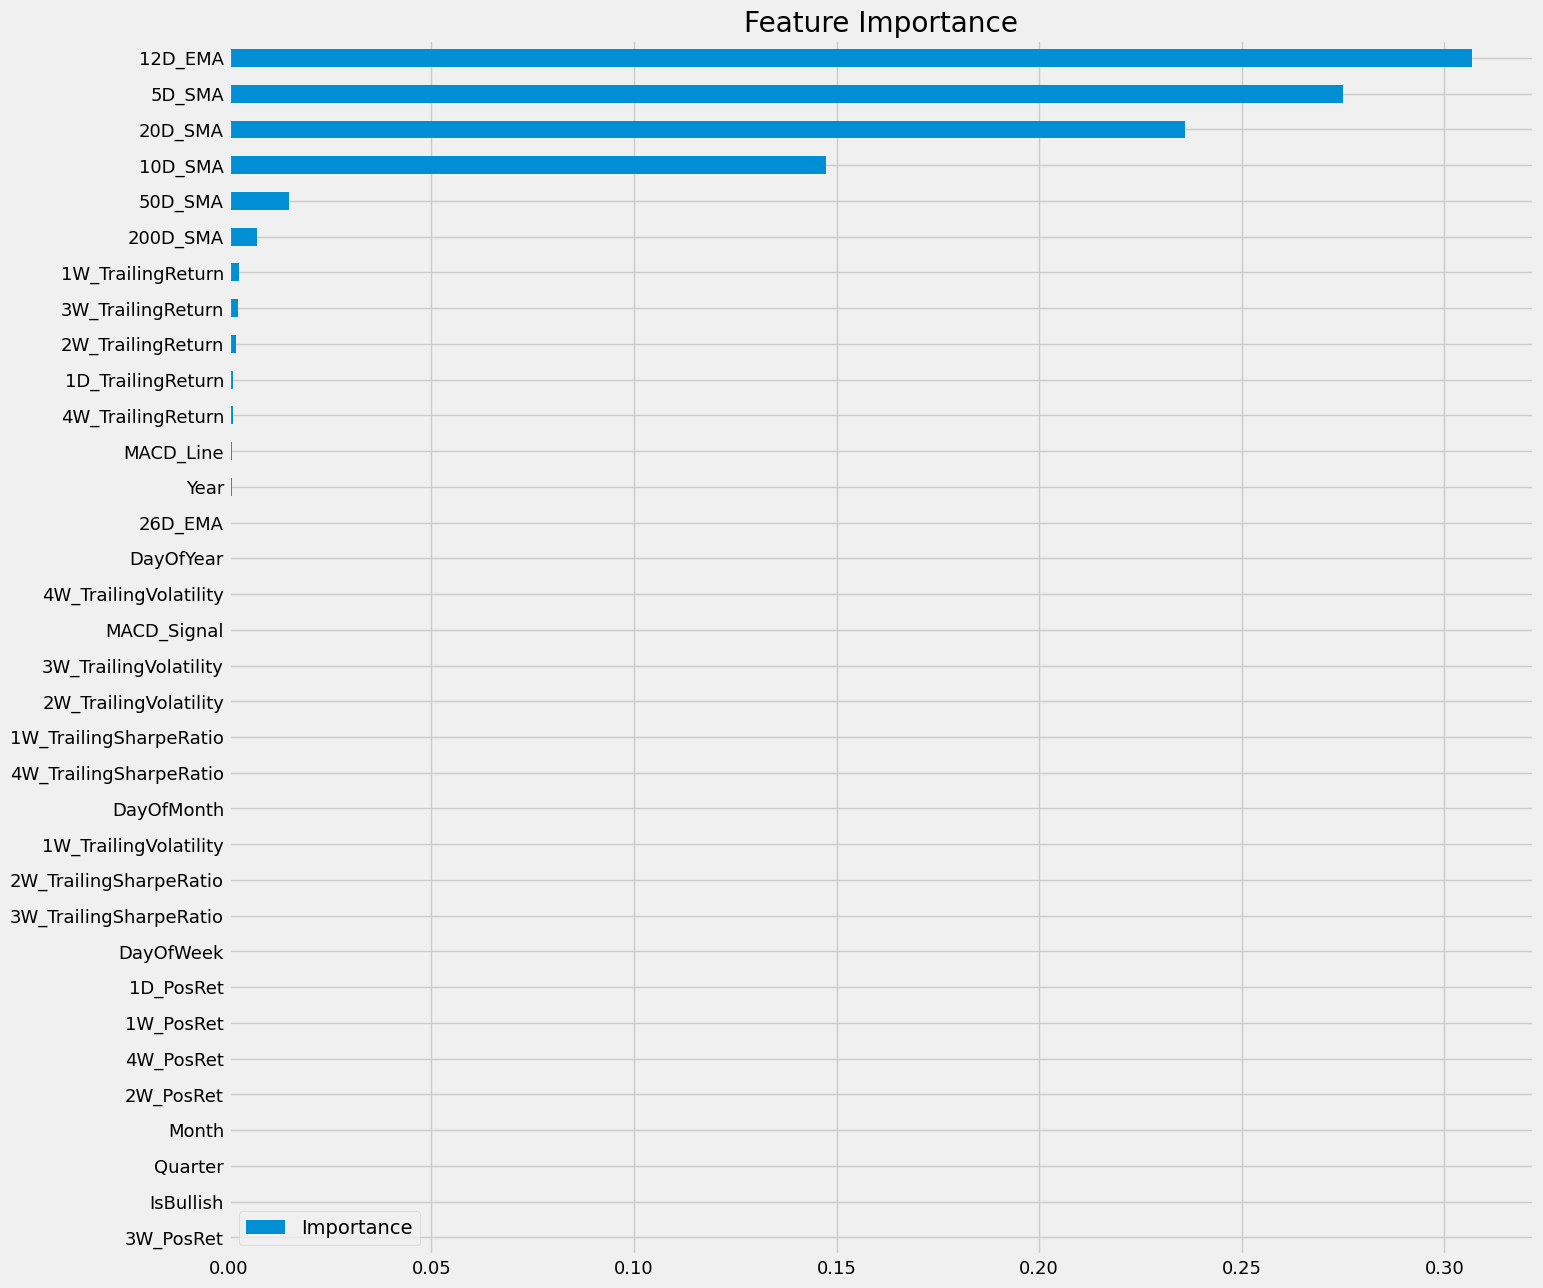

In [12]:
fi = pd.DataFrame(data = final_model.feature_importances_, index = final_model.feature_names_in_,
                  columns = ['Importance'])
fi.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance', fontsize = 13, figsize = (15,15))
plt.show()

## Stock Price Forecasting
Here we downloaded the actual data of 2023, and we handle the data to plot our predictions and compare them with the true data.

In [13]:
# Download data and create future DataFrame

future = pd.date_range('2023-07-01','2023-08-20', freq = "D")
future_df = pd.DataFrame(index = future)
future_df.index = future_df.index.tz_localize('UTC').tz_convert('America/New_York')

future_df['isFuture'] = True
df['isFuture'] = False

present_and_future = pd.concat([df, future_df])
present_and_future.index = pd.to_datetime(present_and_future.index.normalize())
present_and_future = create_features(present_and_future)
present_and_future = create_lag(present_and_future)

In [14]:
future_w_features = present_and_future.query('isFuture').copy()

In [15]:
# Predicting the future and compare with actual data

# Run the model
future_w_features['Prediction'] = final_model.predict(future_w_features[FEATURES])

# Create dataframe to compare the two datasets
comparison_df = pd.DataFrame(chosen_stock.history(start = '2023-07-01', end = '2023-08-20')['Close'])
comparison_df = comparison_df.rename(columns = {'Close' : 'Price'})

final_df = comparison_df.merge(future_w_features['Prediction'], how = 'left', left_index = True, right_index = True)

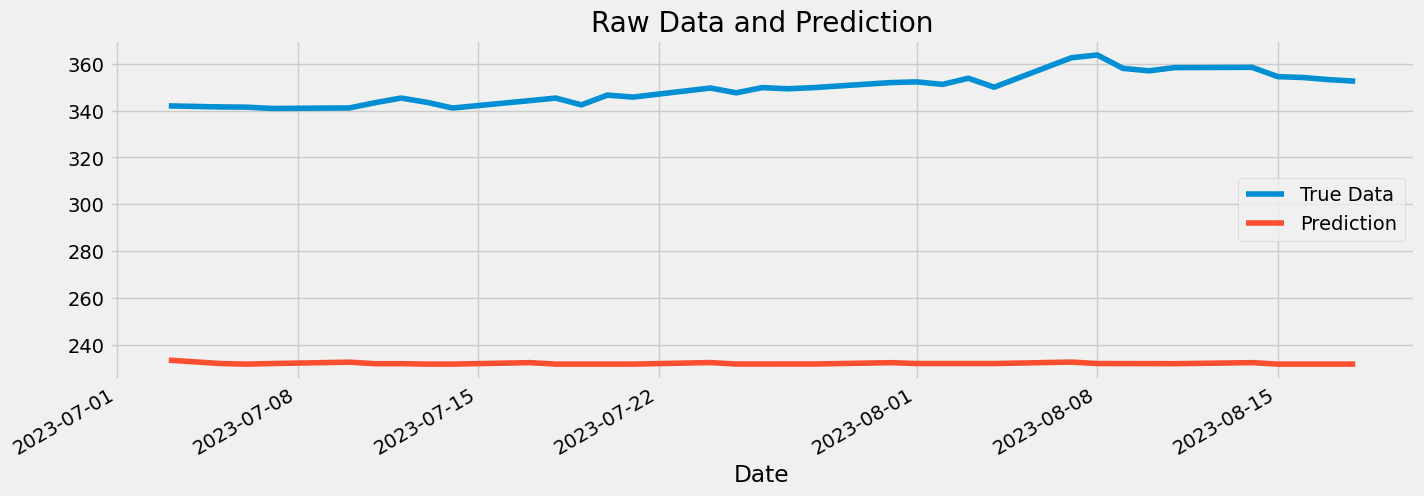

In [16]:
# Plot the data

ax = final_df[['Price']].plot(figsize = (15,5))
final_df['Prediction'].plot(ax = ax)
plt.legend(['True Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

## Calculating Mean Error
Now, we calculate the average error on our prediction, to compare the performance of this model with that of v1.0.

In [17]:
score = np.sqrt(mean_squared_error(final_df['Price'], final_df['Prediction']))
print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 117.69
